In [ ]:
import pickle
import pandas as pd

In [5]:
# transformed dataframe 불러오기
with open('/Users/jjuke/Desktop/Study/BigDataAnalysis/TermProject/SPINDLE DATA/transformed_dataframe.pickle', 'rb') as r:
    transformed_data = pickle.load(r)

transformed_data.head()

,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean
0,"[3968.7937587517504, 3969.793958791758, 3970.7...",3,3,3,0.002493,0.002519,0.002506
1,"[3969.793958791758, 3970.7941588317663, 3971.7...",3,3,3,0.002427,0.002444,0.002435
2,"[3970.7941588317663, 3971.794358871774, 3972.7...",3,3,3,0.002519,0.002536,0.002528
3,"[3970.7941588317663, 3971.794358871774, 3972.7...",5,5,5,0.002050,0.002058,0.002054
4,"[1.0002000400080016, 2.000400080016003, 3.0006...",28,28,21,0.002241,0.002098,0.002180


In [3]:
normalizedf = transformed_data.drop(['Filtered_freq_list'], axis = 1)
normalizedf = (normalizedf - normalizedf.mean())/normalizedf.std()
transformed_data = pd.concat([transformed_data['Filtered_freq_list'], normalizedf], axis = 1)
transformed_data.head()

,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean
0,"[3968.7937587517504, 3969.793958791758, 3970.7...",-4.291769,-4.114624,-3.752816,0.057590,-0.017735,0.050883
1,"[3969.793958791758, 3970.7941588317663, 3971.7...",-4.291769,-4.114624,-3.752816,-0.155662,-0.228152,-0.179486
2,"[3970.7941588317663, 3971.794358871774, 3972.7...",-4.291769,-4.114624,-3.752816,0.141771,0.031307,0.122098
3,"[3970.7941588317663, 3971.794358871774, 3972.7...",-4.078151,-3.851549,-3.437364,-1.365511,-1.316518,-1.425339
4,"[1.0002000400080016, 2.000400080016003, 3.0006...",-1.621547,-0.826193,-0.913746,-0.751061,-1.204531,-1.014634


In [4]:
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66524 entries, 0 to 66523
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    66524 non-null  object 
 1   popCount_freq         66524 non-null  float64
 2   popCount_x            66524 non-null  float64
 3   popCount_y            66524 non-null  float64
 4   popDegree_mean_x      66524 non-null  float64
 5   popDegree_mean_y      66524 non-null  float64
 6   popDegree_total_mean  66524 non-null  float64
dtypes: float64(6), object(1)
memory usage: 3.6+ MB


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.getOrCreate() # initialize SparkSession

dataset = pd.DataFrame({"popCount_x" : transformed_data['popCount_x'],    
                        "popCount_y" : transformed_data['popCount_y'],
                        "popDegree_mean_x": transformed_data['popDegree_mean_x'],
                        "popDegree_mean_y": transformed_data['popDegree_mean_y']}) 
dataset = spark.createDataFrame(dataset)
assembler = VectorAssembler(
    inputCols=["popCount_x", "popCount_y", "popDegree_mean_x", "popDegree_mean_y"]
    ,outputCol= "features"
)

dataset = assembler.transform(dataset)
dataset.show()

In [7]:
# Trains a k-means model.
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Silhouette with squared euclidean distance = 0.5101542000236237
Cluster Centers: 
[ 0.39149775  0.34095726 -0.30274371 -0.28471205]
[-0.78026887 -0.71543765  0.52395208  0.4672952 ]
[-4.30891246 -4.06826831 16.59848393 18.53113136]
[ 6.77358061 14.78167841 -1.77778984  0.97851852]


In [8]:
import matplotlib.pyplot as plt

predictions.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|          popCount_x|          popCount_y|    popDegree_mean_x|    popDegree_mean_y|            features|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  -4.114623525333967| -3.7528161093689287| 0.05759018655037388|-0.01773451935388...|[-4.1146235253339...|         1|
|  -4.114623525333967| -3.7528161093689287|-0.15566168693928334|-0.22815237976642652|[-4.1146235253339...|         1|
|  -4.114623525333967| -3.7528161093689287|  0.1417714637640067|0.031307138182932334|[-4.1146235253339...|         1|
| -3.8515490648862016| -3.4373639121418766| -1.3655105619393544| -1.3165175682097823|[-3.8515490648862...|         1|
| -0.8261927697368984| -0.9137463343254589| -0.7510609805586907| -1.2045310601031352|[-0.8261927697368...|         0|
|   8.512950576158778|  12.019793751983682|  -3.19476630

/var/folders/mn/n0sm8k5d0tl17f99w2qrtt640000gn/T/ipykernel_4525/2186416261.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.3914977502207211, -0.7802688706057762, -4.308912461719698, 6.773580606283391] [0.3409572557288015, -0.7154376450727499, -4.068268306595984, 14.781678414939686] [-0.3027437054546574, 0.5239520833543433, 16.59848392600502, -1.777789837295899]


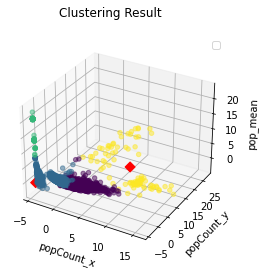

In [12]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
predictions_pandas = predictions.toPandas()

ax.scatter(predictions_pandas['popCount_x'], predictions_pandas['popCount_y'], (predictions_pandas['popDegree_mean_x']+predictions_pandas['popDegree_mean_y'])/2, c=predictions_pandas['prediction'], alpha = 0.5, zorder = 1)
center_x = [row[0] for row in centers]
center_y = [row[1] for row in centers]
center_mean = [row[2] for row in centers]
print(center_x, center_y, center_mean)
ax.scatter(center_x, center_y, [0.008,0.008,0.008, 0.008], s=50, marker = "D", c='r', zorder = 1000000, alpha = 1)
ax.set_xlabel("popCount_x")
ax.set_ylabel("popCount_y")
ax.set_zlabel("pop_mean")
plt.suptitle("Clustering Result")

ax.legend()
plt.show()


In [ ]:
predictions_pandas.shape

(66524, 6)

In [ ]:
import pandas as pd
prediction_list = [[], [], [], []]

total_df = pd.concat([transformed_data['popCount_freq'], predictions_pandas['prediction']], axis = 1)
total_df = total_df.to_numpy()
cnt = 0
for index, data in enumerate(total_df):
    
    if data[1] == 0: prediction_list[0].append((index, data))
    if data[1] == 1: prediction_list[1].append((index, data))
    if data[1] == 2: prediction_list[2].append((index, data))
    if data[1] == 3: prediction_list[3].append((index, data))
print(prediction_list[0][0])
for i in range(4):
    plt.scatter(prediction_list[i][0], prediction_list[i][1][0], c = i, alpha = 0.05)


plt.title("The correlationship between cluster result and the number of outliar frequency")
plt.xlabel("time")
plt.ylabel("the Number of Outliar Frequency")
plt.legend("cluster 0", "cluster 1", "cluster 2", "cluster 3")
plt.show()




In [11]:
resultdf = pd.concat([transformed_data, predictions_pandas['prediction']], axis = 1)
with open('k_means_normalized_k4.pickle', 'wb') as f:
    pickle.dump(resultdf, f)